<a href="https://colab.research.google.com/github/ZhihaoDC/TFG/blob/main/source/marvel_social_network_Louvain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup Environment

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/Github/TFG

!git pull https://github.com/ZhihaoDC/TFG

Mounted at /gdrive
/gdrive/My Drive/Github/TFG
From https://github.com/ZhihaoDC/TFG
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


#Import Libraries

In [2]:
!pip install pyvis

In [62]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import sys
import matplotlib.cm as cm
import community as community_louvain #for testing

from collections import deque, Counter
from tqdm import tqdm #Watch progress bar
from random import shuffle, choice 
from pyvis.network import Network
import community as community_louvain


# import matplotlib.colors as mcolors
# import seaborn as sns

# import statistics
# import math
# import itertools
# import re #regular expressions

# import plotly.express as px
# import plotly.figure_factory as ff

#Read files

*   **nodes**: Node name and type.
*   **edges**: Heroes and the comic in which they appear.
*   ***heroes***: Edges between heroes that appear in the same comic.

In [4]:
nodes = pd.read_csv('./datasets/marvel-social-network/nodes.csv') #Node name and type
edges = pd.read_csv('./datasets/marvel-social-network/edges.csv') #Heroes and the comic in which they appear
heroes = pd.read_csv('./datasets/marvel-social-network/hero-network.csv') # Edges between heroes that appear in the same comic

In [5]:
##Show basic info on dataframes:

# nodes.info() #190.090 rows, 2 columns, no null values
# print('\n')
# edges.info() #96.104 rows, 2 columns, no null values
# print('\n')
# heroes.info() #574.467 rows, 2 columns, no null values

In [6]:
##Peek into the dataframes:

# nodes.head(10)
# edges.head(10)
heroes.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


#Data cleaning

In [7]:
#Remove leading and trailing spaces

nodes = nodes.applymap(lambda x: x.strip())
edges = edges.applymap(lambda x: x.strip())
heroes = heroes.applymap(lambda x: x.strip())

#Graph exploration

In [8]:
#Number of times IronMan/TonyStark has appeared in another hero's comic
heroes.loc[ heroes['hero1']=='IRON MAN/TONY STARK' ].shape[0]

5850

In [9]:
# Number of times Spiderman/PeterParker appeared in the same comic as IronMan/TonyStark
heroes.loc[ (heroes['hero1']=='SPIDER-MAN/PETER PAR') & (heroes['hero2']=='IRON MAN/TONY STARK') ].shape[0]

40

In [10]:
# Number of times IronMan/TonyStark appeared in the same comic as Spiderman/PeterParker
heroes.loc[ (heroes['hero1'] == 'IRON MAN/TONY STARK') & (heroes['hero2'] == 'SPIDER-MAN/PETER PAR') ].shape[0]

54

These two values may be different because of the structure of the edgelist. Maybe a relationship of (hero1=Spiderman, hero2=Ironman) indicates an occurence of Spiderman appearing in an Ironman comic.

In [11]:
#Number different comics in which IronMan/TonyStark has appeared in 
ironman_h1 = heroes.loc[heroes['hero1'] == 'IRON MAN/TONY STARK'].drop_duplicates()
ironman_h1.shape[0]

1131

In [12]:
#Number different heroes that have appeared in a IronMan/TonyStark comic
ironman_h2 = heroes.loc[heroes['hero2'] == 'IRON MAN/TONY STARK'].drop_duplicates()
ironman_h2.shape[0]

1106

In [13]:
#Number of times IronMan has been involved in his or other heroes' comics
ironman_merge = pd.merge(ironman_h1, ironman_h2, how='outer', left_on='hero2', right_on='hero1')
ironman_merge.shape[0]

1521

Since we are interested in a non directed graph, we will ignore this fact for the moment

In [14]:
heroes = heroes.drop_duplicates()

#Generate graph

In [15]:
#Generate Undirected Graph structure

graph = nx.from_pandas_edgelist(heroes, source='hero1', target='hero2') 
graph = graph.to_undirected(graph) # Unweighted undirected graph

print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 6421
Number of edges: 167112
Average degree:  52.0517


The graph density of simple graphs is defined to be the ratio of the number of edges ${\displaystyle |E|}$ with respect to the maximum possible edges
For undirected simple graphs, the graph density is:

${\displaystyle D={\frac {|E|}{\binom {|V|}{2}}}={\frac {2|E|}{|V|(|V|-1)}}}$

where E is the number of edges and V is the number of vertices in the graph.

 The maximum number of edges for an undirected graph is ${\displaystyle {\binom {|V|}{2}}={\frac{|V|(|V|-1)}{2}}}$, so the maximal density is 1 (for complete graphs) and the minimal density is 0

In [16]:
def graph_density(n_vertex, n_edges):
  return (2*n_edges / (n_vertex * (n_vertex - 1)) )

In [17]:
density = graph_density(graph.number_of_nodes(), graph.number_of_edges())
print(density)

0.008107742265085212


In [18]:
#Check graph generation

# #Previously seen:
# #Number of times IronMan has been involved in his or other heroes' comics
# ironman_merge = pd.merge(ironman_h1, ironman_h2, how='outer', left_on='hero2', right_on='hero1')
# ironman_merge.shape[0] 
# #Out: 1521

len(list(graph.edges('IRON MAN/TONY STARK')))

1521

In [19]:
graph_nodes = graph.nodes()

In [20]:
graph_edges = graph.edges()

#Generate subgraph

In [21]:
sort_degrees = sorted(list(graph.degree), key= lambda degree: degree[1], reverse= True)
print(sort_degrees)

[('CAPTAIN AMERICA', 1905), ('SPIDER-MAN/PETER PAR', 1737), ('IRON MAN/TONY STARK', 1521), ('THING/BENJAMIN J. GR', 1416), ('MR. FANTASTIC/REED R', 1377), ('WOLVERINE/LOGAN', 1368), ('HUMAN TORCH/JOHNNY S', 1361), ('SCARLET WITCH/WANDA', 1322), ('THOR/DR. DONALD BLAK', 1289), ('BEAST/HENRY &HANK& P', 1265), ('VISION', 1238), ('INVISIBLE WOMAN/SUE', 1236), ('HAWK', 1175), ('WASP/JANET VAN DYNE', 1091), ('ANT-MAN/DR. HENRY J.', 1082), ('CYCLOPS/SCOTT SUMMER', 1078), ('SHE-HULK/JENNIFER WA', 1071), ('STORM/ORORO MUNROE S', 1070), ('ANGEL/WARREN KENNETH', 1070), ('DR. STRANGE/STEPHEN', 1065), ('HULK/DR. ROBERT BRUC', 1055), ('PROFESSOR X/CHARLES', 1032), ('WONDER MAN/SIMON WIL', 1031), ('COLOSSUS II/PETER RA', 1023), ('MARVEL GIRL/JEAN GRE', 1003), ('HERCULES [GREEK GOD]', 989), ('JARVIS, EDWIN', 986), ('SUB-MARINER/NAMOR MA', 979), ('DAREDEVIL/MATT MURDO', 967), ('ICEMAN/ROBERT BOBBY', 944), ('FURY, COL. NICHOLAS', 922), ('JAMESON, J. JONAH', 920), ('BLACK WIDOW/NATASHA', 920), ('QUICKSIL

In [22]:
#Create subgraph with k greatest degree nodes

#Get top k greatest degree nodes
k = 500
greatest_kdeg = []
for node, degree in sort_degrees[:k]:
  greatest_kdeg.append(node)

#Generate subgraph
subgraph = graph.subgraph(greatest_kdeg)
print(nx.info(subgraph))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 39244
Average degree: 156.9760


In [23]:
# net = Network(notebook=True)
# net.from_nx(subgraph)
# net.repulsion(node_distance=500)
# net.inherit_edge_colors(True)
# net.save_graph('marvel-network-subgraph.html')
# IPython.display.HTML(filename='marvel-network-subgraph.html')

In [24]:
# plt.figure(figsize=(10,10))
# nx.draw_networkx(subgraph)
# plt.show()

#Louvain

##Modularity $Q$

Se puede calcular con la siguiente fómrula:

$Q = \frac{1}{2m}\sum_{i,j}{A_{ij} - \frac{k_i k_j}{2m}}\delta(c_i,c_j)$

Donde $A_{ij}$ es el peso de la arista $(i,j)$, $k_i$ es la suma de los pesos de las aristas que inciden en el nodo $i$, $\delta(c_i,c_j) = 1$ si $c_i = c_j$ y $\delta(c_i,c_j) = 0$ en otro caso y $m$ es la suma del peso de todas las aristas de la red $m = \sum_{i,j}{A_{ij}}$

In [105]:
def modularity(graph, m, community):
  #A_ij ---> weight of edge (i,j)
  #ki ---> sum of the weights attached to i
  #m ---> 1/2 * sum of all edges 
  m = (1/2) * m
  modularity = 0 
  visited = []
  for node in graph.nodes():
    ki = graph.degree(node, 'weight')
    for adj, data in graph[node].items():
      if (community[node] == community[adj]):
        if ((node,adj)) not in visited and ((adj,node) not in visited):
          if (node != adj):
            visited.append((node,adj))
            A_ij = data['weight'] 
            kj = graph.degree(adj, 'weight')
            # print('(', node,',', adj,') ------> ',A_ij, '-' ,'(',ki,'*',kj,'/(',2*m,'))','=',(A_ij - (ki*kj/(2*m))),sep='')

            modularity += (A_ij - (ki*kj/(2*m))) 

  modularity = modularity / (2*m)
  # print(modularity,'||', nx.algorithms.community.quality.modularity(graph,dendrogram(community)))

  return modularity

##Modularity increase $\Delta{Q}$

In [145]:
def mod_increase(graph, m, community, selected, neighbor, ki):
  """Computes the modularity increase for placing 
  'selected_node' in its 'neighbor_node' community.

  Uses formula described in Fast Unfolding of Communities in Large Networks, 
  by Vincent D. Blondel, Jean-Loup Guillaume, Renaud Lambiotte, 
  Journal of Statistical Mechanics Theory and Experiment, April 2008.

  Parameters: 
              graph: networkx.Graph()
              community: dict()
              selected: element from graph.nodes()
              neighbor: graph[selected] 

  Returns: float
  """
  # sum_in --> sum of the weights of the links inside community[neighbor]
  # sum_tot --> sum of weights incident to nodes in community[neighbor]
  # ki --> sum of weights of links incident to i 
  # ki_in --> sum of weights from node i to nodes in community[neighbor]
  # m --> sum of weights of all nodes in the network

  sum_tot = 0
  sum_in = 0
  ki_in = 0

  #compute sum_in, sum_tot
  C = community[neighbor]
  nodes_C = [node for node, com in community.items() if com == C] #nodes in community C
  edges_C = graph.edges(nodes_C, data=True)

  for u,v,data in edges_C:
    weight = data['weight']

    sum_tot += weight

    if ((u in nodes_C) and (v in nodes_C)):
      sum_in += weight

  #compute ki, ki_in
  incident_i = graph.edges(selected, data=True)
  for u,v,data in incident_i:
    weight = data['weight']

    if ((u in nodes_C) and (v == selected)) or ((v in nodes_C) and (u == selected)):
      ki_in += weight

  
  # print('m', m)
  # print('sum_in', sum_in)
  # print('sum_tot',sum_tot )
  # print('ki',ki )
  # print('ki_in',ki_in )

  return (((sum_in + 2*ki_in)/(2*m)) - (((sum_tot + ki)/(2*m))**2) - 
          ((sum_in/(2*m)) - ((sum_tot/(2*m))**2) - (ki/(2*m))**2))

$\Delta Q = \left[\frac{\sum_{in} + 2k_{i,in}}{2m} - \left(\frac{\sum_{tot} + k_i}{2m} \right) ^2 \right] - \left[ \frac{\sum_{in}}{2m} -\left(\frac{\sum_{tot}}{2m}\right)^2 -\left(\frac{k_i}{2m}\right)^2\right]$

In [ ]:
def mod_increase2(graph, community, selected):
  pass

In [27]:
def rename(community):
  """ Renumbers community identifier to lowest range of values possible
  """
  set_values = set(community.values())
  renumbered_values = set(range(len(set_values)))
  renumbered = dict(zip(set_values,renumbered_values))

  transformed = {key:renumbered[value] for key,value in community.items()}

  return transformed

# #Test Code
# my_community = {1:11, 2:22, 3:22, 4:22, 5:4, 6:4, 7:11}
# my_set = set(my_community.values())
# my_set_new = set(range(len(my_set)))

# my_dict = dict(zip(my_set, my_set_new))

# transformed = { key:my_dict[value] for key,value in my_community.items()}

##First step Louvain

In [162]:
def first_step(graph, m, community):
  """Computes one level of communities in Louvain's algorithm
  """
  bestmod_inc = 0
  new_mod = modularity(graph, m, community)
  removing_cost = dict() #cost of removing each node from its community
  k = dict()
  threshold = True
  while threshold:
    mod = new_mod
    nodes = list(graph.nodes())
    shuffle(nodes)
    for node in nodes:
      bestmod_inc = 0
      if node not in k:
        k.update({node: graph.degree(node, 'weight')})
      adj_nodes = list(graph.adj[node])
      shuffle(adj_nodes)
      for adj in adj_nodes:
        if community[node] != community[adj]:
          if adj not in k:
            k.update({adj:graph.degree(adj, 'weight')})
          mod_inc = mod_increase(graph, m, community, node, adj, k[node])
          mod_inc += removing_cost.get(node, 0)
          if mod_inc > bestmod_inc:
            bestmod_inc = mod_inc
            removing_cost.update({node:-bestmod_inc})
            best_com = community[adj]
            community[node] = best_com
            # print(node, '--->', best_com, bestmod_inc)
    new_mod = modularity(graph, m, community)
    # print(new_mod,'>', mod,'?')
    threshold = ((new_mod - mod) > 0.0000001)
    # print(threshold)
  community = rename(community)
  return community

In [47]:
def draw_communities(graph, community):
  """ Draws the graph using colors as community identifier
  """
  pos = nx.spring_layout(graph)
  cmap = cm.get_cmap('viridis', max(community.values()) + 1)
  nx.draw_networkx_nodes(graph, pos, community.keys(), node_size=40,
                        cmap=cmap, node_color=list(community.values()))
  nx.draw_networkx_edges(graph, pos, alpha=0.5)
  plt.show()

In [30]:
def dendrogram(community):
  values = set(list(community.values()))
  dendrogram = []
  for com in values:
    dendrogram.append([key for key,value in community.items() if value == com])
  return dendrogram

In [31]:
def merge_communities(graph, community):
  values = set(community.values())
  new_graph = nx.Graph()
  new_graph.add_nodes_from(values)

  for u, v, data in graph.edges(data=True):
    com1 = community[u]
    com2 = community[v]
    old_weight = new_graph.get_edge_data(com1, com2, default= {'weight' : 0})
    # print(old_weight, data['weight'])
    new_graph.add_edge(com1, com2, weight= old_weight['weight'] + data['weight'])
    # new_graph.add_edge(com1, com2, **{'weight': old_weight + data['weight']})

  return new_graph

In [32]:
def draw_merged_communities(graph):
  pos = nx.spring_layout(graph)
  
  cmap = cm.get_cmap('viridis', graph.number_of_nodes())
  nx.draw_networkx_nodes(graph, pos, node_size=500,
                          cmap=cmap, node_color=graph.nodes())
  
  nx.draw_networkx_edges(graph, pos, alpha=0.5)

  labels = nx.get_edge_attributes(graph,'weight')
  nx.draw_networkx_edge_labels(graph, pos, labels)

  x_values, y_values = zip(*pos.values())
  x_max = max(x_values)
  x_min = min(x_values)
  x_margin = (x_max - x_min) * 0.1
  y_max = max(y_values)
  y_min = min(y_values)
  y_margin = (y_max - y_min) * 0.1

  plt.xlim(x_min - x_margin, x_max + x_margin)
  plt.ylim(y_min - y_margin, y_max + y_margin)
  plt.show()
  plt.show()

##Louvain algorithm

In [33]:
def Louvain(graph):
  """ Detects community in graph using Louvain's algorithm
  """
  communities = []

  graph = graph.copy()

  nx.set_edge_attributes(graph, 1, name='weight')

  n = graph.number_of_nodes()
  m = graph.size('weight')
  community = dict(zip(graph.nodes(), np.arange(n))) #Assign every node to a different community   
  community = first_step(graph, m, community)
  
  mod_new = modularity(graph, m, community)
  mod = mod_new
  communities.append(community)

  graph_new = merge_communities(graph,community)

  while True:
    n = graph_new.number_of_nodes()
    m = graph_new.size('weight')
    community = dict(zip(graph_new.nodes(), np.arange(n))) #Assign every node to a different community  
    print('first step')
    community = first_step(graph_new, m, community)
    print('first step done')
    mod_new = modularity(graph_new, m, community)
    
    if mod_new - mod < 0.0000001:
      print('Exit')
      break
    
    mod = mod_new
    communities.append(community)
    graph_new = merge_communities(graph_new, community)

  return (graph_new, communities)

In [34]:
def last_community(graph, communities):
  summary = communities[0]
  for index in np.arange(1,len(communities)):
    for node, com in summary.items():
      summary[node] = communities[index][com]

  return summary

###Graph example

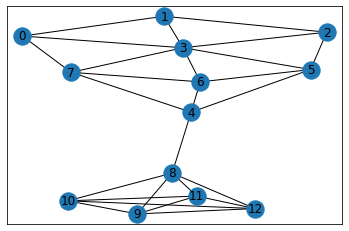

In [35]:
graph_example = nx.Graph()

# nodes = [0,1,2,3,4,5,6,7,8,9,10,11]
edges=[
       (0,1), (0,3),
       (1,2), (1,3),
       (2,3),
       (3,5), (3,6),
       (4,7), (4,5), (4,8),
       (5,2),
       (6,5), (6,7), (6,4),
       (7,3), (7,0),
       (8,9),
       (9,10),
       (10,11), (10,8),
       (11,9), (11,8),
       (12,11), (12,10), (12,9), (12,8)
       ]

# graph.add_nodes_from(nodes)
graph_example.add_edges_from(edges)
nx.set_edge_attributes(graph_example, 1, name='weight')

nx.draw_networkx(graph_example)

##Test first_step

###Test using graph example

0.0
(0,1) ------> 1-(3*3/(26.0))=0.6538461538461539
(1,2) ------> 1-(3*3/(26.0))=0.6538461538461539
(3,5) ------> 1-(6*4/(26.0))=0.07692307692307687
(3,6) ------> 1-(6*4/(26.0))=0.07692307692307687
(3,7) ------> 1-(6*4/(26.0))=0.07692307692307687
(5,6) ------> 1-(4*4/(26.0))=0.3846153846153846
(6,7) ------> 1-(4*4/(26.0))=0.3846153846153846
(8,9) ------> 1-(5*4/(26.0))=0.23076923076923073
(8,10) ------> 1-(5*4/(26.0))=0.23076923076923073
(8,11) ------> 1-(5*4/(26.0))=0.23076923076923073
(8,12) ------> 1-(5*4/(26.0))=0.23076923076923073
(9,10) ------> 1-(4*4/(26.0))=0.3846153846153846
(9,11) ------> 1-(4*4/(26.0))=0.3846153846153846
(9,12) ------> 1-(4*4/(26.0))=0.3846153846153846
(10,11) ------> 1-(4*4/(26.0))=0.3846153846153846
(10,12) ------> 1-(4*4/(26.0))=0.3846153846153846
(11,12) ------> 1-(4*4/(26.0))=0.3846153846153846
0.21301775147929
0.21301775147929 0.0
True
(0,1) ------> 1-(3*3/(26.0))=0.6538461538461539
(0,3) ------> 1-(3*6/(26.0))=0.3076923076923077
(1,2) ------> 1-(3*3/(

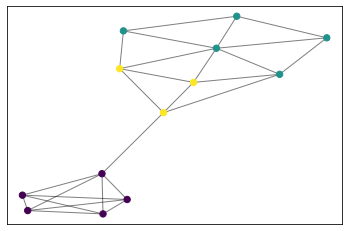

{0, 1, 2}
{0: 1, 1: 1, 3: 1, 2: 1, 5: 1, 6: 2, 4: 2, 7: 2, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}
{0: 1, 1: 1, 3: 1, 2: 1, 5: 1, 6: 1, 4: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}


In [36]:
#Test using graph example

nx.set_edge_attributes(graph_example, 1, name='weight')
n = graph_example.number_of_nodes()
m = graph_example.size()
community = dict(zip(graph_example.nodes(), np.arange(n))) #Assign every node to a different community                                        
community = first_step(graph_example, m, community)
draw_communities(graph_example, community)
print(set(list(community.values())))
print(community)

#Test comparing with networkx's implementation
partition = community_louvain.best_partition(graph_example)
print(partition)

###Test using Zachary's karate club

0.0
(0,1) ------> 1-(16*9/(78.0))=-0.8461538461538463
(0,7) ------> 1-(16*4/(78.0))=0.17948717948717952
(0,13) ------> 1-(16*5/(78.0))=-0.02564102564102555
(0,17) ------> 1-(16*2/(78.0))=0.5897435897435898
(0,19) ------> 1-(16*3/(78.0))=0.3846153846153846
(1,7) ------> 1-(9*4/(78.0))=0.5384615384615384
(1,13) ------> 1-(9*5/(78.0))=0.42307692307692313
(1,17) ------> 1-(9*2/(78.0))=0.7692307692307692
(1,19) ------> 1-(9*3/(78.0))=0.6538461538461539
(4,6) ------> 1-(3*4/(78.0))=0.8461538461538461
(4,10) ------> 1-(3*3/(78.0))=0.8846153846153846
(5,6) ------> 1-(4*4/(78.0))=0.7948717948717949
(5,10) ------> 1-(4*3/(78.0))=0.8461538461538461
(5,16) ------> 1-(4*2/(78.0))=0.8974358974358975
(6,16) ------> 1-(4*2/(78.0))=0.8974358974358975
(8,30) ------> 1-(5*4/(78.0))=0.7435897435897436
(8,32) ------> 1-(5*12/(78.0))=0.23076923076923073
(8,33) ------> 1-(5*17/(78.0))=-0.08974358974358965
(14,32) ------> 1-(2*12/(78.0))=0.6923076923076923
(14,33) ------> 1-(2*17/(78.0))=0.5641025641025641
(1

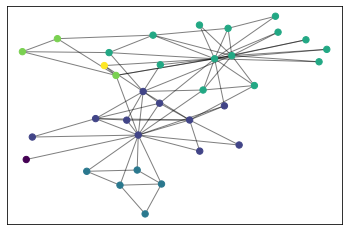

{0, 1, 2, 3, 4, 5}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 1, 8: 3, 9: 3, 10: 2, 11: 0, 12: 1, 13: 1, 14: 3, 15: 3, 16: 2, 17: 1, 18: 3, 19: 1, 20: 3, 21: 1, 22: 3, 23: 3, 24: 4, 25: 4, 26: 3, 27: 3, 28: 5, 29: 3, 30: 3, 31: 4, 32: 3, 33: 3}


In [37]:
#Test one_level using Zachary's karate club dataset
karate = nx.karate_club_graph()
nx.set_edge_attributes(karate, 1, name='weight')
n = karate.number_of_nodes()
m = karate.size('weight')

community = dict(zip(karate.nodes(), np.arange(n))) #Assign every node to a different community                                        
community = first_step(karate, m, community)

draw_communities(karate, community)
values = set(list(community.values()))
print(values)
print(community)

##Test Louvain

first step
first step done
Exit


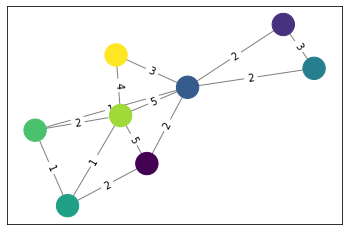

{0, 1, 2, 3, 4, 5, 6, 7}


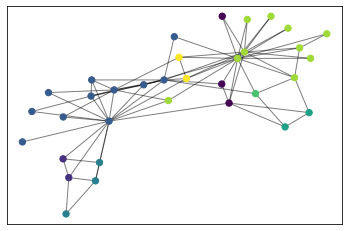

In [161]:
new_graph, communities = Louvain(karate)
draw_merged_communities(new_graph)
lst_community = last_community(karate, communities)
print(set(lst_community.values()))
draw_communities(karate, lst_community)

{0, 1, 2, 3}


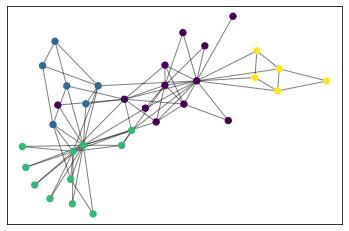

In [70]:
partition = community_louvain.best_partition(karate)
print(set(partition.values()))
draw_communities(karate, partition)

In [40]:
new_graph, communities = Louvain(graph)
# draw_merged_communities(new_graph)
print(communities)

0.0


KeyboardInterrupt: ignored